In [2]:
import pandas as pd
import streamlit as st
import sklearn
import numpy as np
import csv
import json
import matplotlib.pyplot as plt

In [21]:
#CSVs einlesen und DataFrames bauen. Weirde Spalten löschen und ne richtige Zeite Spalte hinzufügen

path = r"C:\Users\ReneJ\Desktop\Data"

light = pd.read_csv(path+ r"\2023-04-22_08-09-30\Light.csv")
displayB = pd.read_csv(path + r"\2023-04-22_08-09-30\Brightness.csv")
battery = pd.read_csv(path + r"\2023-04-22_08-09-30\Battery.csv")
location = pd.read_csv(path + r"\2023-04-22_08-09-30\Location.csv")

dfs =[light, displayB, battery, location]

light["Time"] = pd.to_datetime(light['time'], unit = 'ns')
light.drop(columns=["time", "seconds_elapsed"])

displayB["Time"] = pd.to_datetime(displayB["time"], unit = 'ns')
displayB.drop(columns=["time", "seconds_elapsed"])

battery["Time"] = pd.to_datetime(battery['time'], unit = 'ns')
battery.drop(columns=["time", "seconds_elapsed"])

location["Time"] = pd.to_datetime(location['time'], unit = 'ns')
location.drop(columns=["time", "seconds_elapsed"])

type(location["Time"][0])
location["Time"][0].to_pydatetime()


for df in dfs:
    for i in range(0,len(df["Time"])):
        df["Readable_Time"][i] = df["Time"][i].to_pydatetime()

light


datetime.datetime(2023, 4, 22, 8, 9, 31, 295000)

<function matplotlib.pyplot.show(close=None, block=None)>

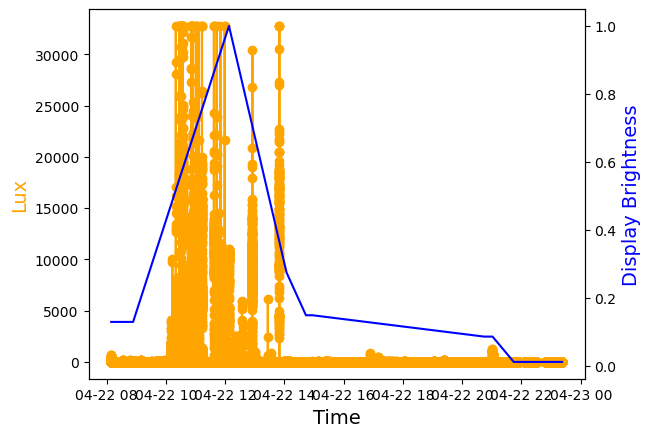

In [9]:
#light.plot(x= "Time", y = "lux")
#displayB.plot(x = "Time", y = "brightness")
#battery.plot(x = "Time", y = "batteryLevel")

fig = plt.subplot()
ax = plt.subplot()
ax.plot(light["Time"], light["lux"], color = "orange", marker = "o")
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Lux", color = "orange", fontsize = 14)

ax2 = ax.twinx()
ax2.plot(displayB["Time"], displayB["brightness"], color = "blue")
ax2.set_ylabel("Display Brightness", color = "blue", fontsize = 14)

plt.show